Converged at iteration 0 with max difference 2.00e-08


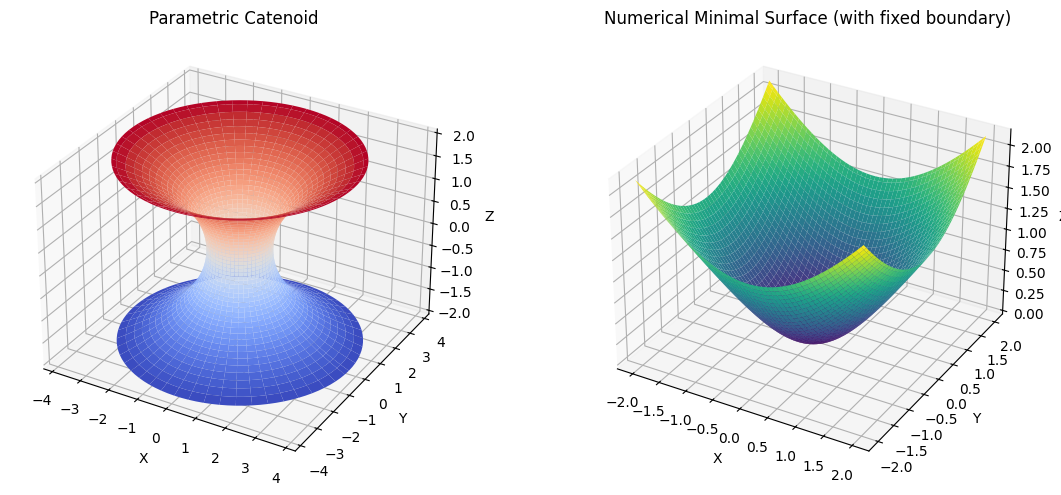

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parametric catenoid (for comparison)
u0 = np.linspace(0, 2 * np.pi, 100)
v0 = np.linspace(-2, 2, 100)
u0, v0 = np.meshgrid(u0, v0)
a = 1
x1 = a * np.cosh(v0) * np.cos(u0)
y1 = a * np.cosh(v0) * np.sin(u0)
z1 = v0

# === Numerical grid ===
nx, ny = 100, 100
x = np.linspace(-2, 2, nx)
y = np.linspace(-2, 2, ny)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

# === Initial guess: log(cosh(sqrt(x^2 + y^2))) ===
R = np.sqrt(X**2 + Y**2)
u = np.log(np.cosh(R))

# === Fix boundary to exact catenoid values ===
# Store the fixed boundary values from the initial guess
u_fixed = np.log(np.cosh(R))
u[0, :] = u_fixed[0, :]
u[-1, :] = u_fixed[-1, :]
u[:, 0] = u_fixed[:, 0]
u[:, -1] = u_fixed[:, -1]

# === Iterative solution ===
max_iter = 5000
# IMPORTANT FIX: Reduced the relaxation parameter significantly.
# A smaller 'relax' value prevents the solution from diverging rapidly
# by taking smaller steps in each iteration.
relax = 1e-8 # Changed from 0.01 to a much smaller value
clip_grad = 10 # Gradient clipping to prevent extreme values

# Define a tolerance for convergence. When the change in 'u' is very small,
# we can stop iterating.
tolerance = 1e-6 # You can adjust this value. Smaller means more precise, but longer.

for it in range(max_iter):
    u_old = u.copy() # Keep a copy of the old state to check for convergence

    # --- Vectorized calculations for derivatives and update ---
    # This section replaces the nested for loops for much faster computation.
    # We operate on slices of the arrays to avoid boundary points.

    # IMPORTANT FIX: Corrected slicing for derivatives to ensure all have the same shape (98, 98)
    # These derivatives correspond to the interior region u[1:-1, 1:-1]

    # Calculate first derivatives using central difference for the interior points
    ux = np.clip((u[1:-1, 2:] - u[1:-1, :-2]) / (2*dx), -clip_grad, clip_grad)
    uy = np.clip((u[2:, 1:-1] - u[:-2, 1:-1]) / (2*dy), -clip_grad, clip_grad)

    # Calculate second derivatives using central difference for the interior points
    uxx = (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) / dx**2
    uyy = (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) / dy**2

    # Calculate mixed second derivative for the interior points
    uxy = (u[2:, 2:] - u[2:, :-2] - u[:-2, 2:] + u[:-2, :-2]) / (4*dx*dy)

    # Denominator term for the minimal surface equation (for interior points)
    # Now ux, uy, uxx, uyy, uxy all have consistent shapes, allowing broadcasting
    denom = 1 + ux**2 + uy**2

    # Numerator term (Laplace-Beltrami operator for minimal surfaces) for interior points
    A = (1 + uy**2)*uxx - 2*ux*uy*uxy + (1 + ux**2)*uyy

    # Update the interior points using relaxation
    # The division by denom is part of the specific form of the minimal surface equation
    # We update only the interior slice u[1:-1, 1:-1]
    u[1:-1, 1:-1] -= relax * A / denom

    # --- End of vectorized calculations ---

    # Fix boundary again after each iteration (to prevent drift)
    # This ensures the boundary conditions are strictly maintained
    u[0, :] = u_fixed[0, :]
    u[-1, :] = u_fixed[-1, :]
    u[:, 0] = u_fixed[:, 0]
    u[:, -1] = u_fixed[:, -1]

    # Check for NaN values to prevent further computation with invalid numbers
    if np.isnan(u).any():
        print("NaN encountered. Stopping iteration.")
        break

    # Check for convergence: If the maximum change in 'u' is very small, stop early.
    diff = np.max(np.abs(u - u_old))
    if diff < tolerance:
        print(f"Converged at iteration {it} with max difference {diff:.2e}")
        break

    # Print progress
    if it % 500 == 0:
        print(f"Iteration {it}, Max difference: {diff:.2e}")


# === Plotting ===
fig = plt.figure(figsize=(12, 5))

# Plot the parametric catenoid
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x1, y1, z1, cmap='coolwarm', edgecolor='none')
ax1.set_title('Parametric Catenoid')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Plot the numerical minimal surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, u, cmap='viridis', edgecolor='none')
ax2.set_title('Numerical Minimal Surface (with fixed boundary)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()